In [1]:
from pandas import read_csv
from matplotlib import pyplot
from scipy.stats import pearsonr

In order to compute the similarities between the datasets,
we first reduce the number of time series for each dataset
to one time series (or prototype) per class. The per class
prototype is computed by averaging the set of time series
in the corresponding class. We used the well-known DTW
Barycenter Averaging (DBA) method to the average a set
of time series [42]. The latter summarizing function was
proposed and validated as an averaging method in the DTW
induced space. In addition, DBA has been recently used as a
data reduction technique where it was evaluated in a nearest
centroid classification schema [43]. Therefore, to generate the
similarity matrix between the UCR datasets, we computed a
distance between each pair of datasets. Finally, for simplicity
and since the main goal of this paper is not the inter-datasets
similarity, we chose the distance between two datasets to be
equal to the minimum distance between the prototypes of their
corresponding classes

##LOAD DATA

In [3]:
from google.colab import drive
drive.mount('/content/drive/')#Smart-Tranfer-Learning-for-TSC-main/')#UCR_TS_Archive_2015/UCR_TS_Archive_2015/')

Mounted at /content/drive/


In [4]:
import os
os.chdir('/content/drive/My Drive/Smart-Tranfer-Learning-for-TSC-main/UCR_TS_Archive_2015/UCR_TS_Archive_2015/')

In [72]:
sources = ['Meat/Meat_TRAIN', 'ECGFiveDays/ECGFiveDays_TRAIN', 'InlineSkate/InlineSkate_TRAIN',   '50words/50words_TRAIN'] # 'HandOutlines/HandOutlines_TRAIN'
targets = ['Wine/Wine_TRAIN',                 'Meat/Meat_TRAIN',             'DiatomSizeReduction/DiatomSizeReduction_TRAIN',  ] # 'ShapeletSim/ShapeletSim_TRAIN'

## DBA
Find represntative time series

In [10]:
!pip3 install dtaidistance
!pip3 install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 7.9 MB/s eta 0:00:00


In [11]:
from pandas import read_csv
from matplotlib import pyplot
from dtaidistance import dtw
from tslearn.barycenters import dtw_barycenter_averaging

import numpy as np
import pandas as pd

In [12]:
def DBA(df_prototype_s, df_prototype_t):
  for i in range(len(df_prototype_s)):
    for j in range(len(df_prototype_t)):
      ts1 = np.array(df_prototype_s.iloc[i])
      ts2 = np.array(df_prototype_t.iloc[j])
      d = dtw.distance_fast(ts1, ts2, use_pruning=True)
      print(d)

In [73]:
df_prototype_s = {}
df_prototype_t = {}

def generate_prototype(df_source, df_target):
  #df_prototype_s = df_source.groupby(level=0).mean()
  #df_prototype_t = df_target.groupby(level=0).mean()

  for i in range(len(df_source)):
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class] = []

  for i in range(len(df_target)):
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class] = []

  for i in range(len(df_source)):
    dfs                       = df_source.iloc[i]
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class].append(dfs.to_numpy())

  for i in range(len(df_target)):
    dft                       = df_target.iloc[i]
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class].append(dft.to_numpy())

  source_barycenters  = {}  # len(df_prototype_s)
  target_barycenters  = {}  # len(df_prototype_t)

  for c in (df_prototype_s.keys()):
    source_barycenters[c] = dtw_barycenter_averaging(df_prototype_s[c])

  for c in (df_prototype_t.keys()):
    target_barycenters[c] = dtw_barycenter_averaging(df_prototype_t[c])

  min_dtw = float("inf")
  min_class = ()

  for i, source_barycenter in source_barycenters.items():
    for j, target_barycenter in target_barycenters.items():
      # Calculate DTW distance
      dtw_distance = dtw.distance(source_barycenter, target_barycenter)

      # Update minimum DTW distance and corresponding class if necessary
      if dtw_distance < min_dtw:
          min_dtw = dtw_distance
          min_class = (i, j)
  print(min_class)
  print(min_dtw)

In [74]:
for s, t in zip(sources, targets):
  print(s, '-', t)
  df_source = read_csv(s, header=None, index_col=0)
  df_target = read_csv(t, header=None, index_col=0)
  generate_prototype(df_source, df_target)

Meat/Meat_TRAIN - Wine/Wine_TRAIN
(2, 1)
6.5469717781685
ECGFiveDays/ECGFiveDays_TRAIN - Meat/Meat_TRAIN


KeyboardInterrupt: ignored

##Pearson Correlation

In [89]:
df_prototype_s = {}
df_prototype_t = {}

def generate_prototype(df_source, df_target, plts):
  #df_prototype_s = df_source.groupby(level=0).mean()
  #df_prototype_t = df_target.groupby(level=0).mean()

  #Equalize lengths
  num_columns = min(len(df_source.columns),len(df_target.columns))
  df_source.drop(columns=df_source.columns[num_columns:], axis=1, inplace=True)
  df_target.drop(columns=df_target.columns[num_columns:], axis=1, inplace=True)

  for i in range(len(df_source)):
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class] = []

  for i in range(len(df_target)):
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class] = []

  for i in range(len(df_source)):
    dfs                       = df_source.iloc[i]
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class].append(dfs.to_numpy())

  for i in range(len(df_target)):
    dft                       = df_target.iloc[i]
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class].append(dft.to_numpy())

  source_barycenters  = {}  # len(df_prototype_s)
  target_barycenters  = {}  # len(df_prototype_t)

  #DBA method to get prototypes
  for c in (df_prototype_s.keys()):
    source_barycenters[c] = dtw_barycenter_averaging(df_prototype_s[c])

  for c in (df_prototype_t.keys()):
    target_barycenters[c] = dtw_barycenter_averaging(df_prototype_t[c])

  max_corr = -float("inf")
  best_class = ()
  for i, source_barycenter in source_barycenters.items():
    for j, target_barycenter in target_barycenters.items():
           
      source_barycenter = np.reshape(source_barycenter,[len(source_barycenter)])
      target_barycenter = np.reshape(target_barycenter,[len(target_barycenter)])
      #Pearson correlation Distance
      pearson_corr, _ = pearsonr(source_barycenter, target_barycenter)

      if pearson_corr > max_corr:
          max_corr = pearson_corr
          best_class = (i, j)
  print(best_class)
  print(max_corr)
  plt.figure(plts)
  plt.plot(source_barycenters[i])
  plt.plot(target_barycenters[j])
  return source_barycenters[i], target_barycenters[j]

Meat/Meat_TRAIN - Wine/Wine_TRAIN
(2, 1)
0.14139560407927362
Meat/Meat_TRAIN - Meat/Meat_TRAIN
(1, 1)
1.0
Meat/Meat_TRAIN - DiatomSizeReduction/DiatomSizeReduction_TRAIN
(2, 1)
0.3023976845441984


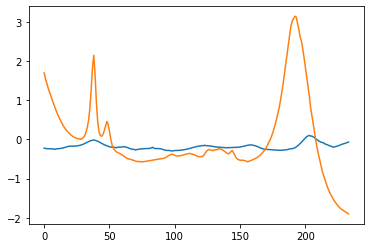

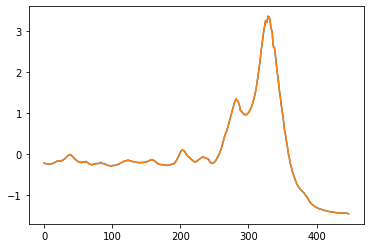

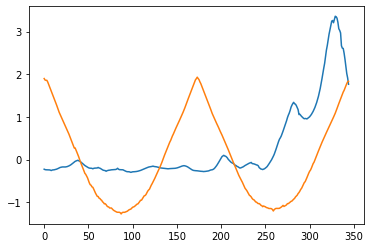

In [90]:
plts = 1
import matplotlib.pyplot as plt
for s in sources[:1]:
  for  t in targets:
    print(s, '-', t)
    df_source = read_csv(s, header=None, index_col=0)
    df_target = read_csv(t, header=None, index_col=0)
    plts+=1
    generate_prototype(df_source, df_target, plts)



##TLCC

In [112]:
df_prototype_s = {}
df_prototype_t = {}

def generate_prototype(df_source, df_target, plts):
  #df_prototype_s = df_source.groupby(level=0).mean()
  #df_prototype_t = df_target.groupby(level=0).mean()

  #Equalize lengths
  num_columns = min(len(df_source.columns),len(df_target.columns))
  #df_source.drop(columns=df_source.columns[num_columns:], axis=1, inplace=True)
  #df_target.drop(columns=df_target.columns[num_columns:], axis=1, inplace=True)

  for i in range(len(df_source)):
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class] = []

  for i in range(len(df_target)):
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class] = []

  for i in range(len(df_source)):
    dfs                       = df_source.iloc[i]
    dfs_class                 = df_source.iloc[i].name
    df_prototype_s[dfs_class].append(dfs.to_numpy())

  for i in range(len(df_target)):
    dft                       = df_target.iloc[i]
    dft_class                 = df_target.iloc[i].name
    df_prototype_t[dft_class].append(dft.to_numpy())

  source_barycenters  = {}  # len(df_prototype_s)
  target_barycenters  = {}  # len(df_prototype_t)

  #DBA method to get prototypes
  for c in (df_prototype_s.keys()):
    source_barycenters[c] = dtw_barycenter_averaging(df_prototype_s[c])

  for c in (df_prototype_t.keys()):
    target_barycenters[c] = dtw_barycenter_averaging(df_prototype_t[c])

  max_corr = -float("inf")
  max_corr_argmax = 0
  best_class = ()
  for i, source_barycenter in source_barycenters.items():
    for j, target_barycenter in target_barycenters.items():
           
      source_barycenter = np.reshape(source_barycenter,[len(source_barycenter)])
      target_barycenter = np.reshape(target_barycenter,[len(target_barycenter)])
      #Pearson correlation Distance
      pearson_corr = sm.tsa.stattools.ccf(source_barycenter, target_barycenter, adjusted=False)
      
      if pearson_corr.max() > max_corr:
          max_corr = pearson_corr.max()
          max_corr_argmax = pearson_corr.argmax()
          best_class = (i, j)
  print(best_class)
  print("Max TLCC correlation" , max_corr)
  print(max_corr_argmax)
  plt.figure(plts)
  plt.plot(source_barycenters[i])
  plt.plot(target_barycenters[j])
  plt.plot(max_corr_argmax, source_barycenters[i][max_corr_argmax], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
  #plt.plot((max_corr_argmax, source_barycenters[i][max_corr_argmax]))
  #plt.plot((max_corr_argmax, target_barycenters[j][max_corr_argmax]))
  return source_barycenters[i], target_barycenters[j]

Meat/Meat_TRAIN - Wine/Wine_TRAIN
(2, 2)
0.2113498075781517
102
Meat/Meat_TRAIN - Meat/Meat_TRAIN
(2, 2)
1.0000000000000002
0
Meat/Meat_TRAIN - DiatomSizeReduction/DiatomSizeReduction_TRAIN
(2, 1)
0.6090340178759103
52


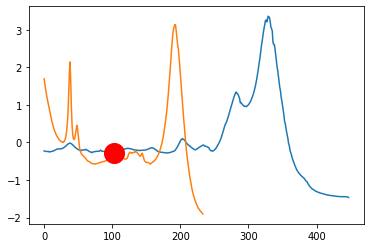

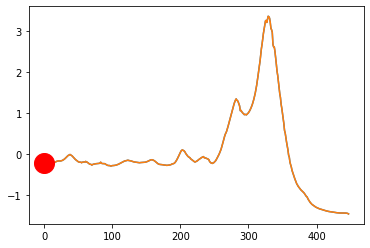

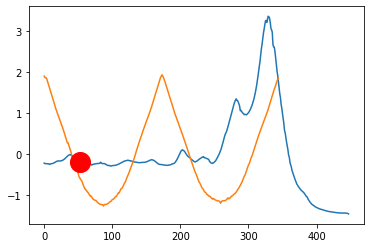

In [113]:
plts = 1
import matplotlib.pyplot as plt
import statsmodels.api as sm


for s in sources[:1]:
  for  t in targets:
    print(s, '-', t)
    df_source = read_csv(s, header=None, index_col=0)
    df_target = read_csv(t, header=None, index_col=0)
    plts+=1
    generate_prototype(df_source, df_target, plts)



The red point shows the point from which maximum correlation is observed 

In [ ]:
import statsmodels.api as sm

#calculate cross correlation
tlcc = sm.tsa.stattools.ccf(df1.iloc[1], df2.iloc[1], adjusted=False)


In [ ]:
tlcc

array([0.24409428, 0.24498763, 0.24584897, ..., 0.00219568, 0.0014916 ,
       0.00073137])

In [ ]:
tlcc.max()

0.48980435974594594

In [ ]:
tlcc.argmax()

199

We offset the entire datasets by 1029 for training

In [ ]:
import matplotlib.pyplot as plt

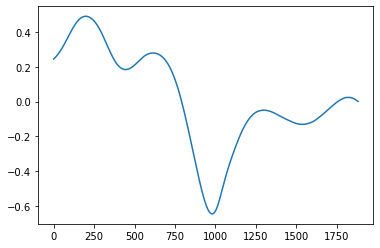

In [ ]:
plt.plot(tlcc)

## Visualization

In [ ]:
df1

,1,2,3,4,5,6,7,8,9,10,...,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882
0,,,,,,,,,,,,,,,,,,,,,
2,-0.036166,-0.151640,-0.089001,-0.133280,-0.077171,-0.117890,-0.081651,-0.092772,-0.093733,-0.086446,...,-0.140390,-0.152270,-0.183840,-0.165660,-0.149100,-0.155760,-0.180100,-0.12786,-0.192020,-0.110380
2,-0.554270,-0.593670,-0.579670,-0.602390,-0.604810,-0.601310,-0.604460,-0.632650,-0.620530,-0.630410,...,-0.466000,-0.462560,-0.492210,-0.469990,-0.495640,-0.493980,-0.531910,-0.49810,-0.537830,-0.517410
3,0.149520,0.026359,0.167520,0.054150,0.092847,0.085971,0.109040,0.105860,0.105700,0.107180,...,0.407590,0.401730,0.413610,0.418240,0.401960,0.404070,0.403470,0.37642,0.367230,0.409760
7,-0.363130,-0.646230,-0.693990,-0.515550,-0.631540,-0.628680,-0.601330,-0.651290,-0.617220,-0.612940,...,-0.451170,-0.436120,-0.433550,-0.452010,-0.404250,-0.458800,-0.524100,-0.41348,-0.552420,-0.562540
6,0.090731,-0.092733,-0.026174,-0.064635,-0.089953,-0.062950,-0.079535,-0.083377,-0.101650,-0.109250,...,-0.050490,-0.049658,-0.062375,-0.073720,-0.097504,-0.103050,-0.082875,-0.14308,-0.078123,-0.142350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-0.109750,-0.234050,-0.147190,-0.234710,-0.194010,-0.236220,-0.213820,-0.228060,-0.248190,-0.259780,...,-0.541170,-0.547200,-0.562610,-0.557520,-0.548480,-0.581820,-0.573110,-0.55364,-0.628800,-0.523310
6,0.127900,-0.000188,0.031357,0.107760,0.048947,0.080089,0.105490,0.073951,0.070994,0.064312,...,0.054495,0.049642,0.068174,0.066708,0.074728,0.075721,0.054056,0.11070,0.090602,0.052547
6,-0.729890,-0.902960,-0.775570,-0.863180,-0.837530,-0.813620,-0.840030,-0.840140,-0.850770,-0.848230,...,-0.604730,-0.591820,-0.592820,-0.617410,-0.615490,-0.621520,-0.584290,-0.61942,-0.581230,-0.604630


In [ ]:
df1.loc[2]

,1,2,3,4,5,6,7,8,9,10,...,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882
0,,,,,,,,,,,,,,,,,,,,,
2,-0.036166,-0.151640,-0.089001,-0.13328,-0.077171,-0.117890,-0.081651,-0.092772,-0.093733,-0.086446,...,-0.14039,-0.15227,-0.183840,-0.16566,-0.14910,-0.15576,-0.18010,-0.127860,-0.19202,-0.110380
2,-0.554270,-0.593670,-0.579670,-0.60239,-0.604810,-0.601310,-0.604460,-0.632650,-0.620530,-0.630410,...,-0.46600,-0.46256,-0.492210,-0.46999,-0.49564,-0.49398,-0.53191,-0.498100,-0.53783,-0.517410
2,-0.474410,-0.817140,-0.554510,-0.70125,-0.647080,-0.678700,-0.689580,-0.665330,-0.698670,-0.684370,...,-0.44983,-0.47576,-0.460780,-0.47893,-0.46080,-0.52768,-0.48762,-0.545520,-0.50410,-0.484760
2,-0.606260,-0.746320,-0.666570,-0.72195,-0.672380,-0.694610,-0.707680,-0.740820,-0.712720,-0.728800,...,-0.52266,-0.51290,-0.537470,-0.53891,-0.53150,-0.51295,-0.56033,-0.510800,-0.56690,-0.478890
2,0.585310,0.537880,0.570570,0.53082,0.585530,0.531840,0.571210,0.556600,0.537400,0.572720,...,-0.12763,-0.12685,-0.095703,-0.12915,-0.13467,-0.11080,-0.11060,-0.081575,-0.16145,-0.074976
2,-0.369320,-0.689330,-0.452450,-0.62404,-0.561880,-0.562580,-0.602000,-0.568010,-0.578450,-0.600270,...,-0.35515,-0.30914,-0.306680,-0.33956,-0.32637,-0.36656,-0.33142,-0.431870,-0.38239,-0.350110
2,0.322010,0.310640,0.321180,0.29116,0.283110,0.302470,0.307120,0.294820,0.280610,0.304080,...,0.49557,0.49182,0.483790,0.49300,0.46733,0.45871,0.44554,0.461830,0.44243,0.465050
2,-0.402870,-0.747820,-0.527440,-0.68560,-0.596780,-0.585870,-0.620460,-0.596600,-0.623120,-0.650760,...,-0.73863,-0.74539,-0.747980,-0.75178,-0.73235,-0.78023,-0.72569,-0.803230,-0.75721,-0.753560
2,-0.004913,-0.080048,-0.035154,-0.09727,-0.055195,-0.068475,-0.077105,-0.093561,-0.094781,-0.109120,...,-0.27678,-0.26595,-0.260400,-0.26741,-0.29044,-0.27732,-0.29036,-0.278210,-0.33261,-0.266260


In [ ]:
df1_2 = df1.loc[2]
df1_1 = df1.loc[1]
df1_3 = df1.loc[3]

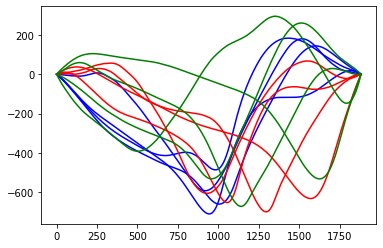

In [ ]:
for i in range(4):
    ts = df1_2.iloc[i]
    ts = ts.cumsum()
    ts.plot(color = 'b', label = 'class 2', use_index=True)

for i in range(4):
    ts = df1_3.iloc[i]
    ts = ts.cumsum()
    ts.plot(color = 'r', label = 'class 1')

for i in range(4):
    ts = df1_1.iloc[i]
    ts = ts.cumsum()
    ts.plot(color = 'g', label = 'class 1')

In [ ]:
df2

,1,2,3,4,5,6,7,8,9,10,...,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882
0,,,,,,,,,,,,,,,,,,,,,
1,-2.3312,-2.3312,-2.3356,-2.3400,-2.3443,-2.3465,-2.3465,-2.3465,-2.3464,-2.3461,...,1.35810,1.34980,1.34110,1.34010,1.33460,1.32600,1.31760,1.30900,1.30040,1.29170
1,-2.3374,-2.3374,-2.3374,-2.3374,-2.3397,-2.3397,-2.3397,-2.3397,-2.3397,-2.3395,...,0.86990,0.86069,0.85148,0.84398,0.83477,0.82786,0.81866,0.81175,0.80255,0.79334
0,-2.3414,-2.3436,-2.3458,-2.3546,-2.3568,-2.3590,-2.3590,-2.3590,-2.3590,-2.3588,...,1.19210,1.18330,1.17460,1.16580,1.15710,1.15060,1.14920,1.14830,1.13950,1.13080
1,-2.3892,-2.3892,-2.3892,-2.3892,-2.3892,-2.3892,-2.3914,-2.3914,-2.3890,-2.3908,...,1.19720,1.18970,1.18110,1.17250,1.16390,1.15480,1.14400,1.13540,1.12850,1.12410
1,-2.3643,-2.3643,-2.3665,-2.3709,-2.3753,-2.3753,-2.3753,-2.3731,-2.3708,-2.3706,...,1.12240,1.11330,1.10470,1.09650,1.08740,1.07880,1.07020,1.06160,1.05290,1.04430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-2.3619,-2.3619,-2.3619,-2.3619,-2.3619,-2.3642,-2.3642,-2.3641,-2.3640,-2.3637,...,1.26220,1.25320,1.24420,1.23520,1.22620,1.21730,1.20600,1.19700,1.19110,1.18960
1,-2.3482,-2.3482,-2.3482,-2.3482,-2.3482,-2.3507,-2.3507,-2.3507,-2.3507,-2.3504,...,1.18510,1.17790,1.16820,1.15860,1.15130,1.14170,1.13210,1.12480,1.11520,1.10800
1,-2.1880,-2.1905,-2.1905,-2.1905,-2.1905,-2.1905,-2.1905,-2.1905,-2.1905,-2.1905,...,0.81062,0.80514,0.79826,0.79085,0.78343,0.77602,0.77108,0.76367,0.75626,0.74885


In [ ]:
df1_2 = df2.loc[0]
df1_1 = df2.loc[1]

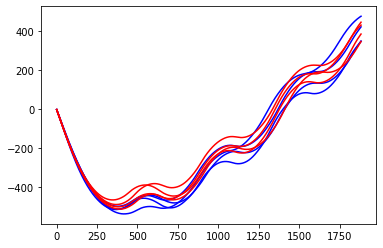

In [ ]:
for i in range(4):
    ts = df1_2.iloc[i]
    ts = ts.cumsum()
    ts.plot(color = 'b', label = 'class 2', use_index=True)

for i in range(4):
    ts = df1_1.iloc[i]
    ts = ts.cumsum()
    ts.plot(color = 'r', label = 'class 1')

# New Section

In [ ]:
df1

,1,2,3,4,5,6,7,8,9,10,...,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882
0,,,,,,,,,,,,,,,,,,,,,
2,-0.036166,-0.151640,-0.089001,-0.133280,-0.077171,-0.117890,-0.081651,-0.092772,-0.093733,-0.086446,...,-0.140390,-0.152270,-0.183840,-0.165660,-0.149100,-0.155760,-0.180100,-0.12786,-0.192020,-0.110380
2,-0.554270,-0.593670,-0.579670,-0.602390,-0.604810,-0.601310,-0.604460,-0.632650,-0.620530,-0.630410,...,-0.466000,-0.462560,-0.492210,-0.469990,-0.495640,-0.493980,-0.531910,-0.49810,-0.537830,-0.517410
3,0.149520,0.026359,0.167520,0.054150,0.092847,0.085971,0.109040,0.105860,0.105700,0.107180,...,0.407590,0.401730,0.413610,0.418240,0.401960,0.404070,0.403470,0.37642,0.367230,0.409760
7,-0.363130,-0.646230,-0.693990,-0.515550,-0.631540,-0.628680,-0.601330,-0.651290,-0.617220,-0.612940,...,-0.451170,-0.436120,-0.433550,-0.452010,-0.404250,-0.458800,-0.524100,-0.41348,-0.552420,-0.562540
6,0.090731,-0.092733,-0.026174,-0.064635,-0.089953,-0.062950,-0.079535,-0.083377,-0.101650,-0.109250,...,-0.050490,-0.049658,-0.062375,-0.073720,-0.097504,-0.103050,-0.082875,-0.14308,-0.078123,-0.142350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-0.109750,-0.234050,-0.147190,-0.234710,-0.194010,-0.236220,-0.213820,-0.228060,-0.248190,-0.259780,...,-0.541170,-0.547200,-0.562610,-0.557520,-0.548480,-0.581820,-0.573110,-0.55364,-0.628800,-0.523310
6,0.127900,-0.000188,0.031357,0.107760,0.048947,0.080089,0.105490,0.073951,0.070994,0.064312,...,0.054495,0.049642,0.068174,0.066708,0.074728,0.075721,0.054056,0.11070,0.090602,0.052547
6,-0.729890,-0.902960,-0.775570,-0.863180,-0.837530,-0.813620,-0.840030,-0.840140,-0.850770,-0.848230,...,-0.604730,-0.591820,-0.592820,-0.617410,-0.615490,-0.621520,-0.584290,-0.61942,-0.581230,-0.604630
